In [1]:
# General
import os
import gc
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import ast
# Imports the Abstract Syntax Trees module.
# This module is used to safely evaluate or parse Python expressions (e.g., converting a string representation of a Python literal into an actual object).
# Unlike eval(), ast.literal_eval() only allows literals like strings, numbers, tuples, lists, dicts, booleans, and None — making it safer.
# Example: ast.literal_eval("{'style': 'casual', 'color': 'blue'}") → {'style': 'casual', 'color': 'blue'}
import time
import json 
# Imports the built-in JSON module to read from and write to JSON (JavaScript Object Notation) files.
# JSON is commonly used to store and exchange data in structured key-value formats (like dictionaries).
# This is especially useful for saving chatbot data, user preferences, model outputs, and configuration files.

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display

# Audio processing
import librosa  # A popular library for audio and music analysis.
# It helps with loading audio files, extracting features (like tempo, pitch, MFCCs), and performing signal processing.
# Commonly used in audio classification, music genre detection, and speech-related tasks.

import soundfile as sf  # Library for reading and writing audio files.
# It supports formats like WAV, FLAC, and OGG, and works well with NumPy arrays.
# Useful for saving processed or generated audio to disk.

# Machine Learning / Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
 # A library built on top of PyTorch for audio processing.
# It provides tools to load, transform, and augment audio data as PyTorch tensors.
# Useful for building deep learning models for tasks like speech recognition, speaker identification, and sound classification.
# Supports integration with pretrained models and pipelines in PyTorch.

# Model and Optimizer
import timm
from torch.optim import Adam

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set display options
pd.set_option('display.max_columns', 100)

These audio parameters are used to convert raw audio signals into Mel-spectrograms, which are commonly used as input features for machine learning models in audio classification tasks, like identifying bird calls or speech.

What is a Mel-spectrogram?

A Mel-spectrogram is a time-frequency representation of an audio signal where:

* Time runs along the x-axis (horizontal)
* Frequency is on the y-axis (vertical), scaled using the Mel scale, which mimics how humans perceive pitch
* The color or intensity represents the amplitude (loudness) of each frequency over time

The Mel scale spaces frequencies **closer together at lower frequencies and farther apart at higher frequencies**, matching human hearing sensitivity.

---

### How the parameters are used:

| Parameter            | Role                                                                                |
| -------------------- | ----------------------------------------------------------------------------------- |
| `SR` (Sampling Rate) | Audio is resampled or loaded at this rate, so all clips are uniformly sampled       |
| `DURATION`           | Audio is trimmed or padded to this duration (e.g., 5 seconds per sample)            |
| `HOP_LENGTH`         | Defines the number of samples between two successive frames in the spectrogram      |
| `N_MELS`             | Controls how many Mel-frequency bands are used in the spectrogram                   |
| `FMIN` & `FMAX`      | These set the frequency range to consider; 20 Hz to Nyquist frequency (half the SR) |

---

### Why use Mel-spectrograms?

* They compress audio data into a manageable 2D image-like form
* They match how humans perceive sound, making them more effective for models
* Most audio models (like CNNs or transformers for audio) take Mel-spectrograms as input instead of raw waveforms



In [2]:
class CFG:
    # Paths
    TRAIN_AUDIO_DIR = "/kaggle/input/birdclef-2025/train_audio"
    TRAIN_SOUNDSCAPE_DIR = "/kaggle/input/birdclef-2025/train_soundscapes"
    TEST_SOUNDSCAPE_DIR = "/kaggle/input/birdclef-2025/test_soundscapes"
    TRAIN_CSV = "/kaggle/input/birdclef-2025/train.csv"
    TAXONOMY_CSV = "/kaggle/input/birdclef-2025/taxonomy.csv"
    SAMPLE_SUBMISSION_CSV = "/kaggle/input/birdclef-2025/sample_submission.csv"
    RECORDING_LOCATION = "/kaggle/input/birdclef-2025/recording_location.txt"

    
    
    # Audio Parameters
    SR = 32000              # Sampling rate: number of audio samples per second
    DURATION = 5            # Duration (in seconds) of each audio clip
    HOP_LENGTH = 512        # Hop length: step size between frames for spectrogram
    N_MELS = 128            # Number of Mel bands (frequency bins) for Mel-spectrogram
    FMIN = 20               # Minimum frequency for Mel scale
    FMAX = SR // 2          # Maximum frequency for Mel scale (Nyquist frequency)

    # Model Parameters
    MODEL_NAME = "tf_efficientnet_b0"  
    PRETRAINED = True
    NUM_CLASSES = 206  

    # Training Parameters
    EPOCHS = 1
    BATCH_SIZE = 3
    LR = 1e-4
    SEED = 42
    NUM_WORKERS = 2


   # Inference
    THRESHOLD = 0.5
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # Debug Mode
    DEBUG = False

cfg = CFG()




| Operation                                     | Description                                                                                            |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **random.seed(seed)**                         | Sets the seed for Python's built-in random number generator for reproducibility in Python operations.  |
| **np.random.seed(seed)**                      | Sets the seed for NumPy's random number generator, ensuring deterministic random operations in NumPy.  |
| **torch.manual\_seed(seed)**                  | Sets the seed for random number generation in PyTorch (CPU operations), ensuring reproducible results. |
| **torch.cuda.manual\_seed(seed)**             | Sets the seed for random number generation in PyTorch on GPU (CUDA operations) for reproducibility.    |
| **torch.backends.cudnn.deterministic = True** | Forces the CuDNN backend (used by PyTorch) to use deterministic operations for reproducibility.        |
| **torch.backends.cudnn.benchmark = False**    | Disables CuDNN's benchmarking feature to ensure the same algorithms are used for reproducibility.      |

This table summarizes the purpose of each operation to ensure deterministic behavior and reproducibility in the model's execution.

**Deterministic operations** refer to processes that produce the same output every time they are executed with the same input, ensuring reproducibility in experiments.

**Benchmarking** refers to testing and evaluating the performance of different algorithms or hardware configurations to find the most efficient option, often at the cost of introducing minor variations in the results.


I used **deterministic operations** to ensure that the results of my deep learning models are consistent across multiple runs, which is crucial for reproducibility in research and debugging. This is especially important when testing and comparing model performance or when troubleshooting issues. On the other hand, I disabled **benchmarking** to prioritize reproducibility over performance optimization. While benchmarking would speed up the training process by selecting the best algorithms for my hardware, it may introduce slight variations in results. Therefore, for consistency and reliable results in my experiments, I chose to disable it.



In [3]:
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)

Loading Dataset

In [4]:
df_taxonomy = pd.read_csv(cfg.TAXONOMY_CSV)
df_train = pd.read_csv(cfg.TRAIN_CSV)

In [5]:
df_train

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0


In [6]:
# Convert stringified lists to actual Python lists
for col in ['secondary_labels', 'type']:
    df_train[col] = df_train[col].apply(lambda x: ast.literal_eval(x))

# Add full path to audio files
df_train['filepath'] = df_train['filename'].apply(lambda x: os.path.join(cfg.TRAIN_AUDIO_DIR, x))

# Preview
df_train.sample(5)

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,filepath
27685,yeofly1,[],[call],yeofly1/XC250351.ogg,XC,4.0,https://xeno-canto.org/250351,-4.4010,-79.8540,Tolmomyias sulphurescens,Yellow-olive Flycatcher,Niels Krabbe,cc-by-sa 4.0,/kaggle/input/birdclef-2025/train_audio/yeofly...
25019,whbman1,[],[mechanical sounds],whbman1/XC268585.ogg,XC,5.0,https://xeno-canto.org/268585,-19.7323,-41.8141,Manacus manacus,White-bearded Manakin,Fabrice Schmitt,cc-by-nc-sa 4.0,/kaggle/input/birdclef-2025/train_audio/whbman...
96,21211,[],[],21211/XC913998.ogg,XC,3.0,https://xeno-canto.org/913998,4.0946,-52.6862,Allobates femoralis,Spotted-thighed Poison Frog,Delaitre guillaume,cc-by-nc-sa 4.0,/kaggle/input/birdclef-2025/train_audio/21211/...
5771,bugtan,[],[flight call],bugtan/XC480423.ogg,XC,5.0,https://xeno-canto.org/480423,-0.4383,-76.2791,Thraupis episcopus,Blue-gray Tanager,Jerome Fischer,cc-by-nc-sa 4.0,/kaggle/input/birdclef-2025/train_audio/bugtan...
21879,strher,"[greani1, grekis]",[flight call],strher/XC287867.ogg,XC,3.5,https://xeno-canto.org/287867,-22.4508,-42.7735,Butorides striata,Striated Heron,Jerome Fischer,cc-by-nc-sa 4.0,/kaggle/input/birdclef-2025/train_audio/strher...


This code block is a crucial preprocessing step that prepares the bird audio dataset for use in a machine learning pipeline. First, it converts string representations of lists in the `secondary_labels` and `type` columns into actual Python list objects using `ast.literal_eval()`. This is important because CSV files often store lists as plain strings, which are not directly usable for tasks like label comparison or iteration. By converting them into real lists, we enable smooth handling of multi-label classification problems and further data processing. Next, the code creates a new column called `filepath` by joining the base directory path of the training audio files with each individual filename. This generates a full path for every audio file, which is essential when we need to load these files during training or evaluation. Without these paths, the model wouldn’t be able to locate the audio clips. Finally, the `.sample(5)` line is used to display five random rows from the DataFrame, helping verify that the changes—like list conversion and path generation—have been applied correctly. These steps ensure the dataset is clean, consistent, and ready for use in model training or feature extraction.


EDA

In [7]:
# Check shape and column details
print("Shape of training data:", df_train.shape)
print("Columns:", df_train.columns.tolist())
df_train.info()

Shape of training data: (28564, 14)
Columns: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'filepath']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     28564 non-null  object 
 1   secondary_labels  28564 non-null  object 
 2   type              28564 non-null  object 
 3   filename          28564 non-null  object 
 4   collection        28564 non-null  object 
 5   rating            28564 non-null  float64
 6   url               28564 non-null  object 
 7   latitude          27755 non-null  float64
 8   longitude         27755 non-null  float64
 9   scientific_name   28564 non-null  object 
 10  common_name       28564 non-null  object 
 11  author            28564 non-null  object 
 12  li

In [8]:
# Check missing values
df_train.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
filepath              0
dtype: int64

In [9]:
# How many unique bird labels?
print("Number of unique bird species:", df_train['primary_label'].nunique())

# Most common species
df_train['primary_label'].value_counts().head(10)

Number of unique bird species: 206


primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
Name: count, dtype: int64

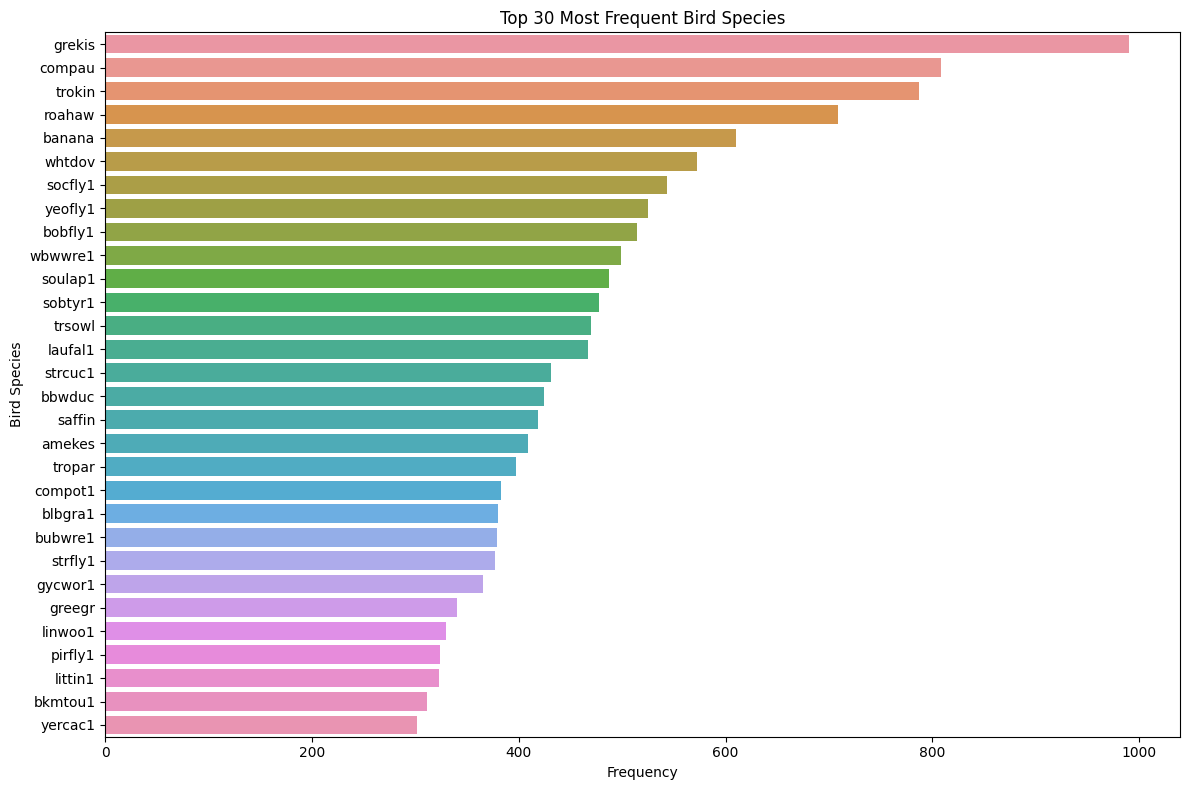

In [10]:
plt.figure(figsize=(12, 8))
sns.countplot(y='primary_label', data=df_train,
              order=df_train['primary_label'].value_counts().iloc[:30].index)
plt.title("Top 30 Most Frequent Bird Species")
plt.xlabel("Frequency")
plt.ylabel("Bird Species")
plt.tight_layout()
plt.show()

In [11]:
# Count unique values in 'rating'
rating_counts = df_train['rating'].value_counts().sort_index()
print(rating_counts)

rating
0.0    7948
0.5      26
1.0     228
1.5      70
2.0     752
2.5     360
3.0    2886
3.5     895
4.0    7582
4.5    1261
5.0    6556
Name: count, dtype: int64


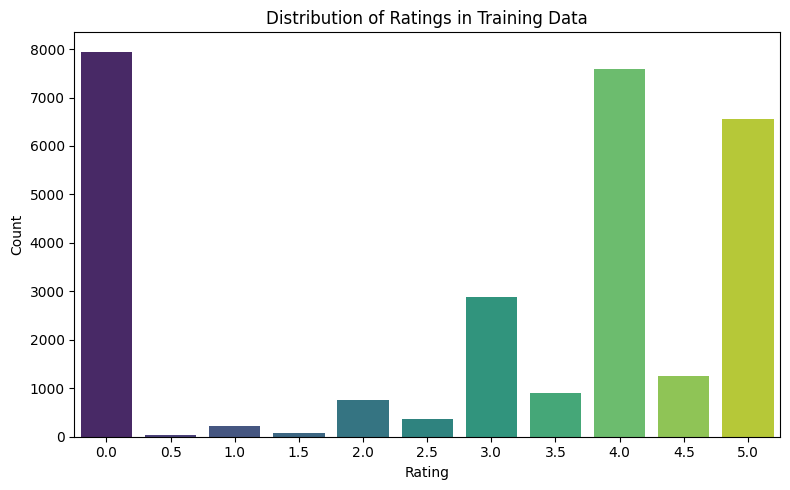

In [12]:
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")

plt.title("Distribution of Ratings in Training Data")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

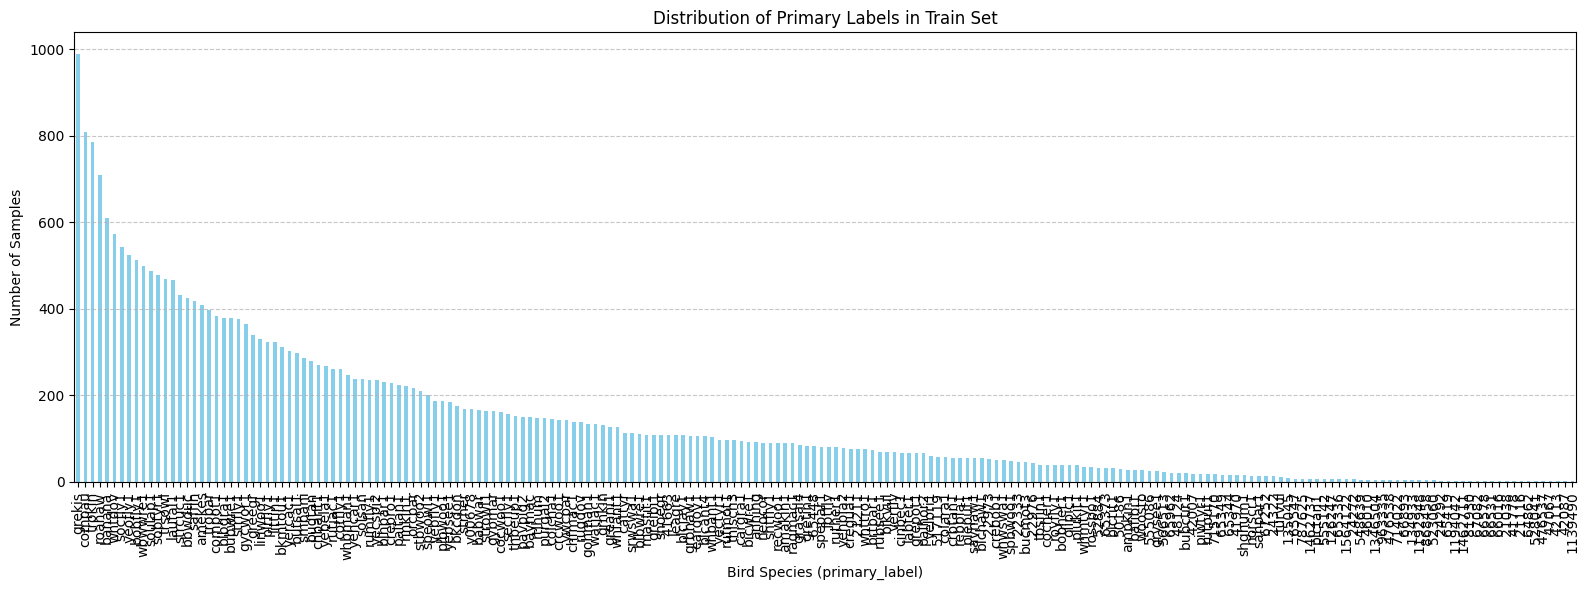

In [13]:
# Plot class distribution of primary labels
plt.figure(figsize=(16, 6))
df_train["primary_label"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribution of Primary Labels in Train Set")
plt.xlabel("Bird Species (primary_label)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

This code defines a function called `plot_mel_spectrogram` which takes the file path of an audio recording and creates a visual representation of its sound called a **Mel spectrogram**. First, it uses `librosa.load()` to load the audio signal (`y`) and sampling rate (`sr`). The sampling rate defines how many times per second the audio was sampled (typically 32,000 times per second here). Then, it computes a **Mel spectrogram** using `librosa.feature.melspectrogram()`, which transforms the audio from the time domain into the frequency domain, showing how energy is distributed across different frequency bands over time. The frequencies are mapped using the **Mel scale**, which mimics how human ears perceive pitch — giving more resolution to lower frequencies and less to higher ones. After that, it converts the amplitude values into **decibels** (a logarithmic scale) using `librosa.power_to_db()` to better reflect how we hear differences in volume. The final spectrogram is plotted using `librosa.display.specshow()`, with time on the x-axis and Mel frequency bins on the y-axis. A color bar is added to show the amplitude in dB, and the entire plot is styled and displayed. This visualization helps us understand what the sound looks like — for example, you can see patterns that correspond to chirps, calls, or silence in a bird audio recording.


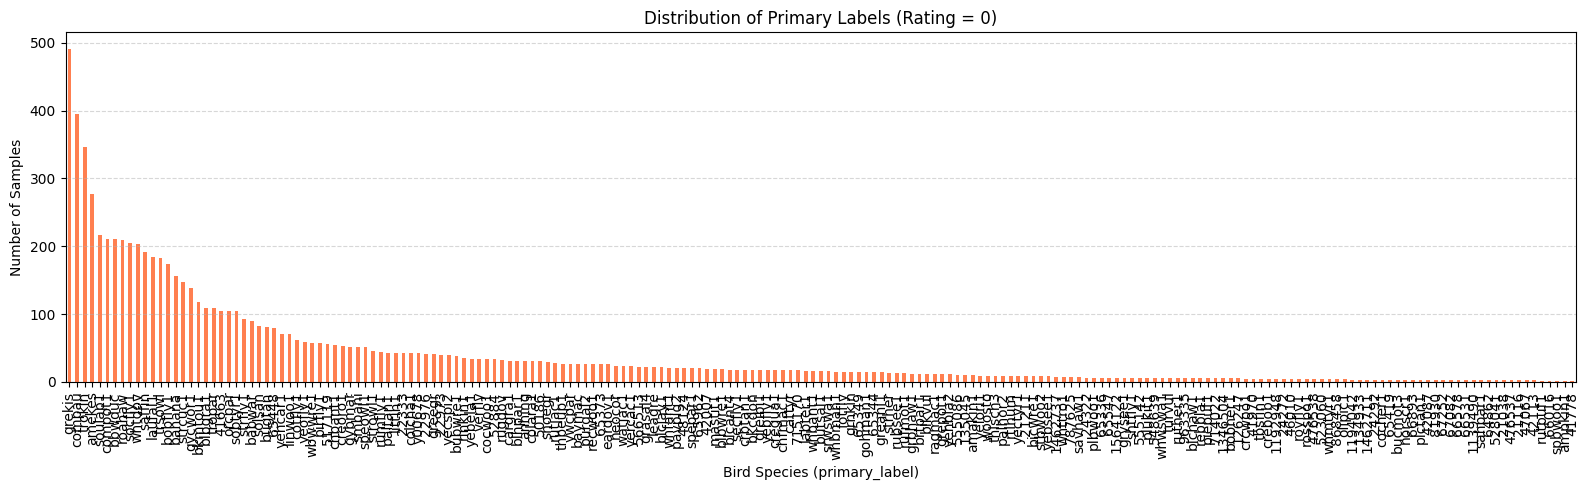

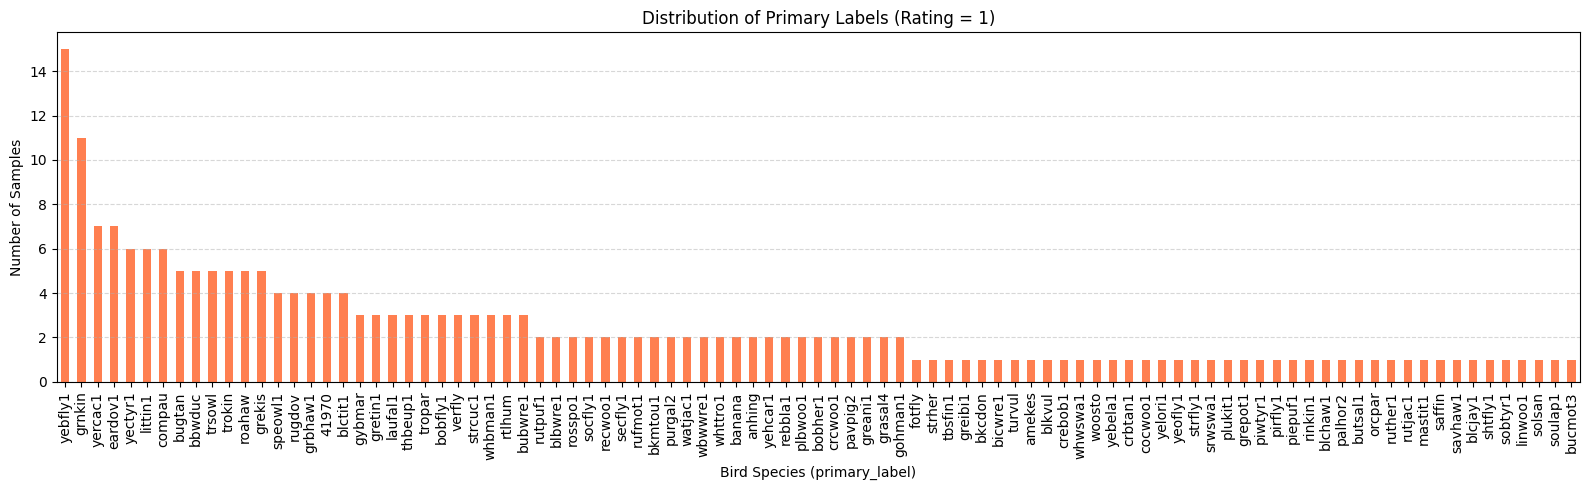

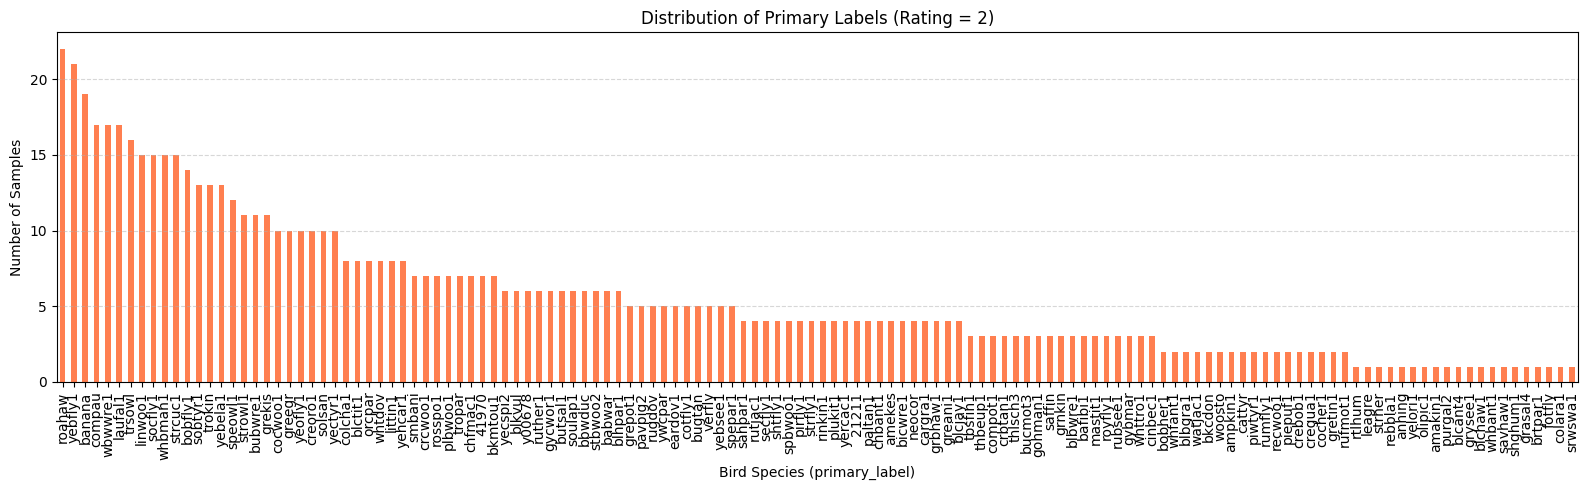

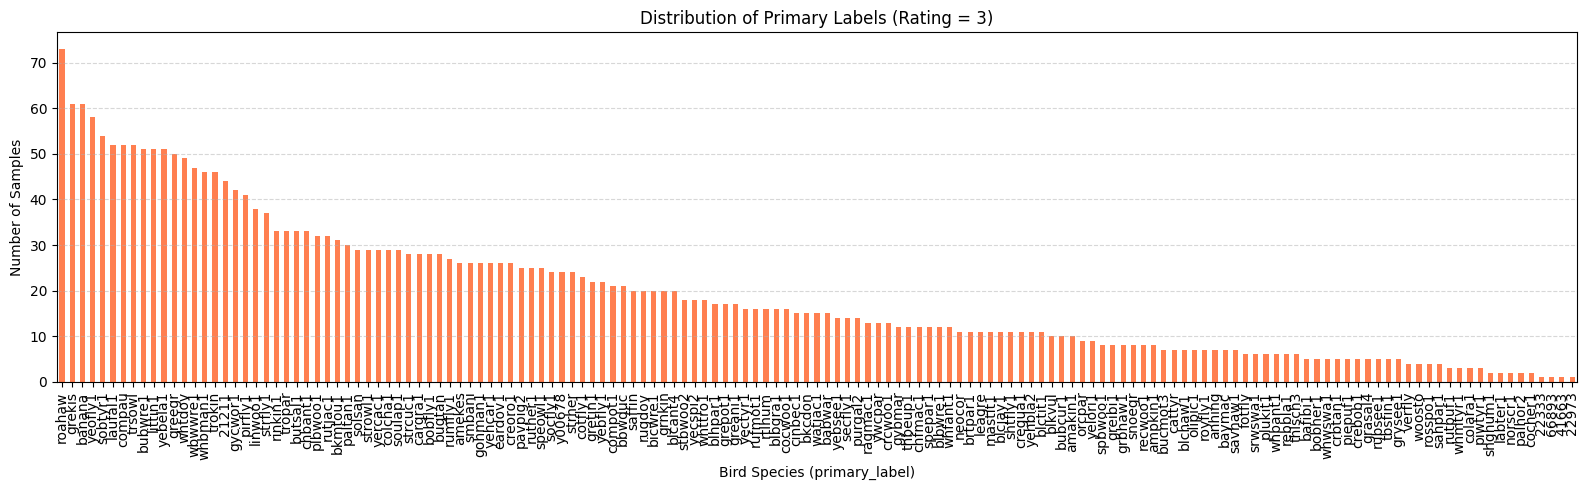

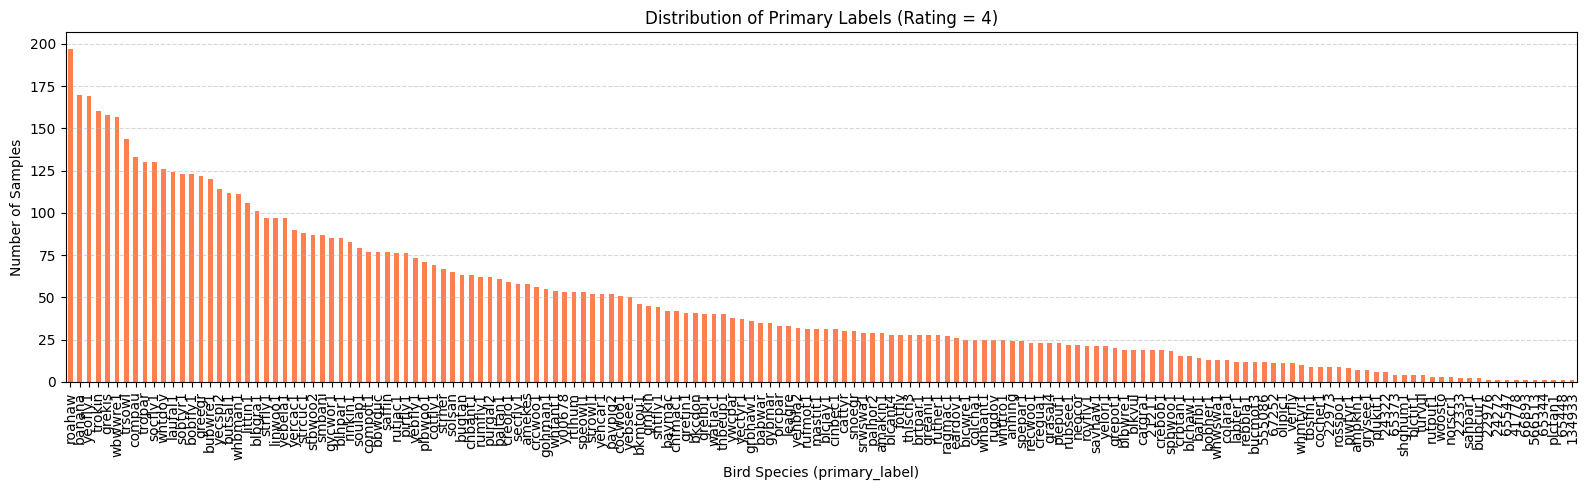

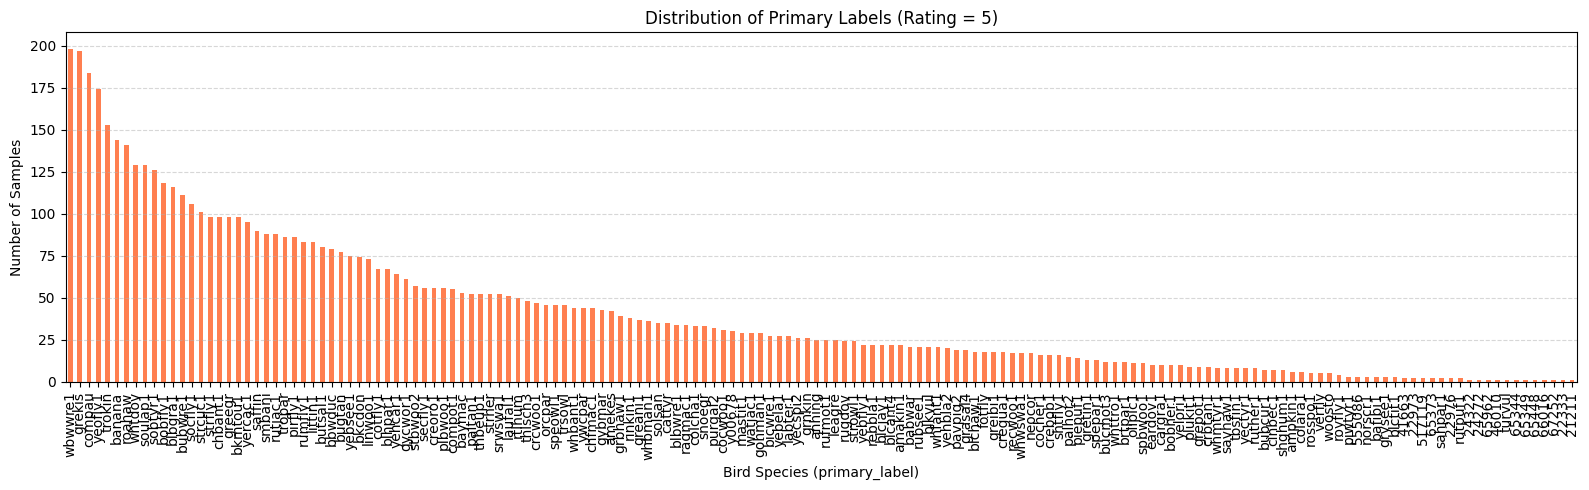

In [19]:
# Plot distribution of primary_label for each rating (0 to 5)
for r in range(6):
    df_rated = df_train[df_train["rating"] == r]
    
    if df_rated.empty:
        print(f"No data found for rating = {r}")
        continue
    
    plt.figure(figsize=(16, 5))
    df_rated["primary_label"].value_counts().plot(kind="bar", color="coral")
    plt.title(f"Distribution of Primary Labels (Rating = {r})")
    plt.xlabel("Bird Species (primary_label)")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

  0%|          | 0/28564 [00:00<?, ?it/s]

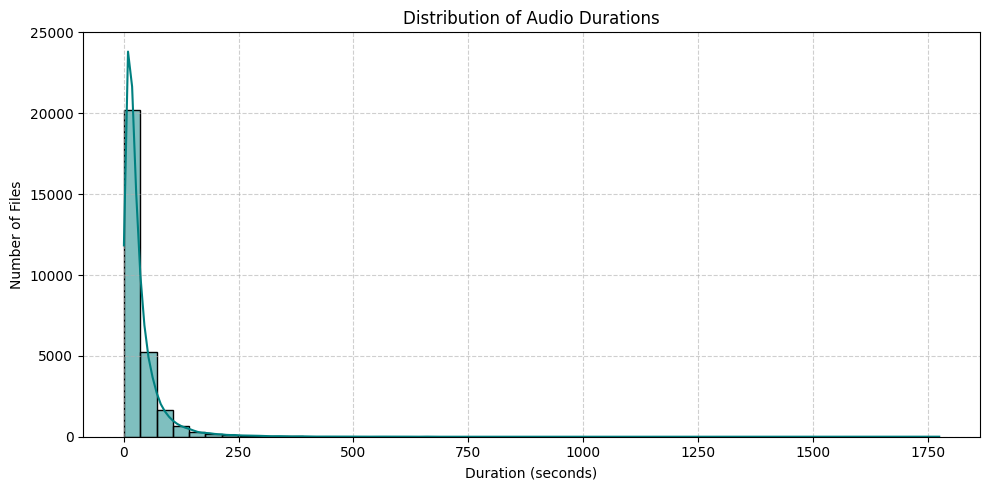

In [14]:
# Compute duration for each audio file
def get_duration(path):
    f = sf.SoundFile(path)
    return len(f) / f.samplerate

# Apply to all audio files
tqdm.pandas()
df_train["duration"] = df_train["filepath"].progress_apply(get_duration)

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_train["duration"], bins=50, kde=True, color="teal")
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Files")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [17]:
# Plot Mel Spectrogram
def plot_mel_spectrogram(path, sr=cfg.SR, n_mels=cfg.N_MELS, fmin=cfg.FMIN, fmax=cfg.FMAX, hop_length=cfg.HOP_LENGTH):
    y, sr = librosa.load(path, sr=sr)
    
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(
        mel_spec_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel", fmax=fmax
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

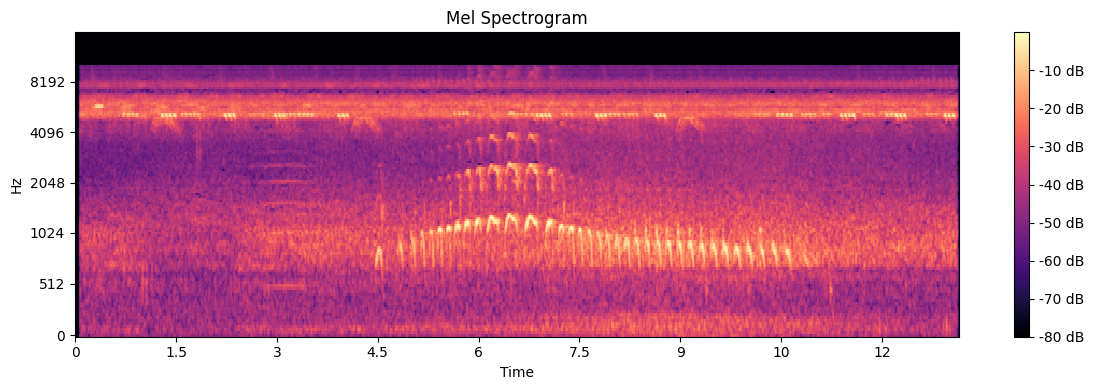

In [18]:
# Pick a random audio file
sample_path = df_train.sample(1)["filepath"].values[0]
plot_mel_spectrogram(sample_path)

Sample 11009 - Primary Label: grekis


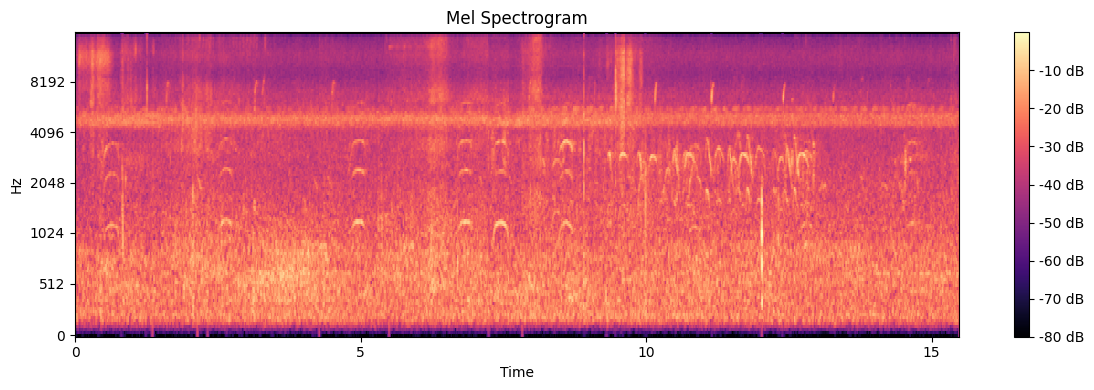

Sample 21944 - Primary Label: strher


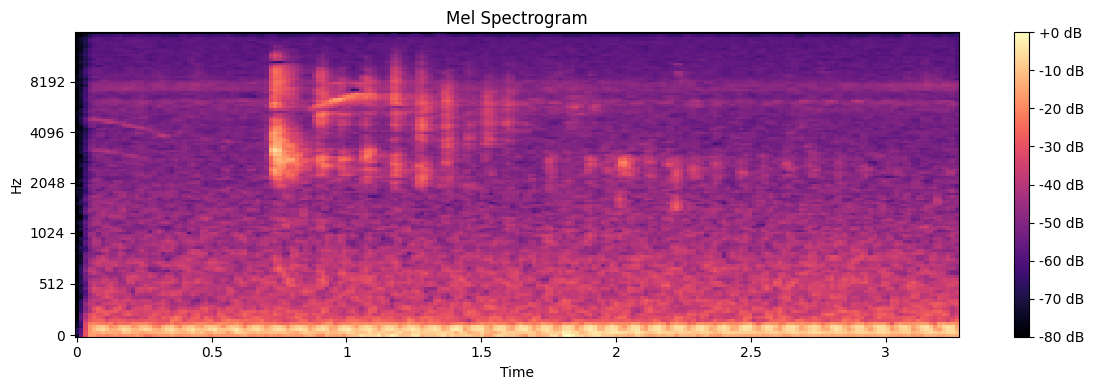

Sample 13912 - Primary Label: orcpar


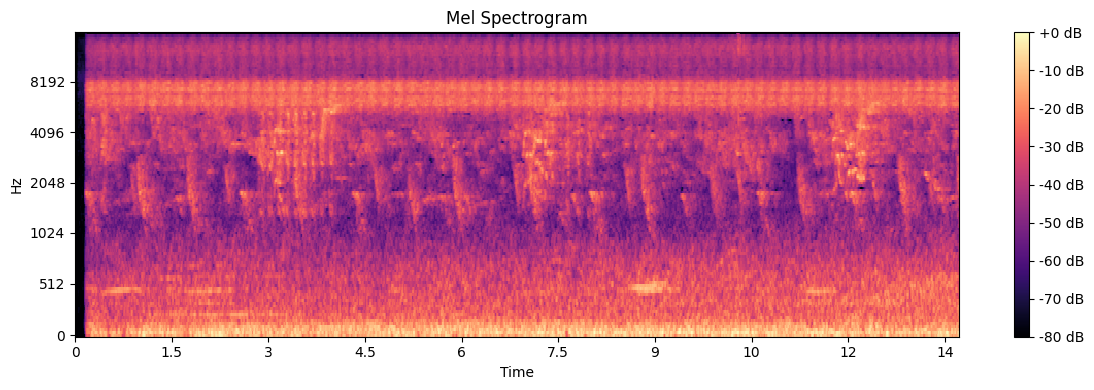

Sample 20546 - Primary Label: speowl1


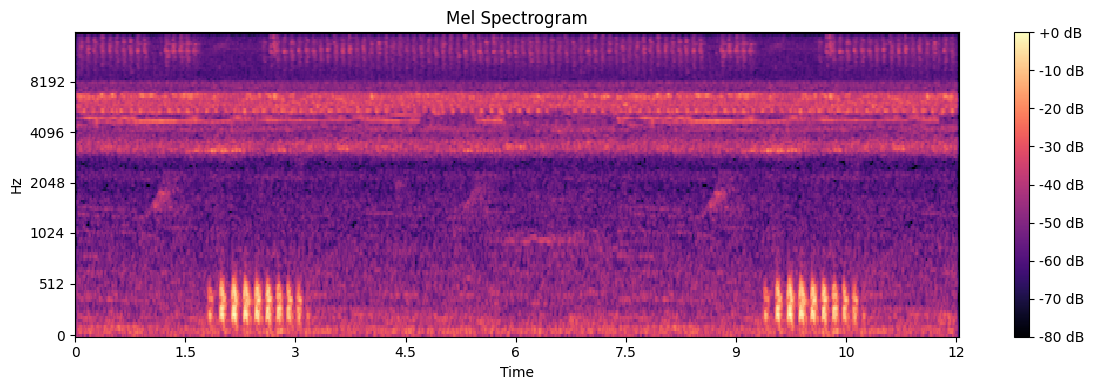

Sample 12599 - Primary Label: laufal1


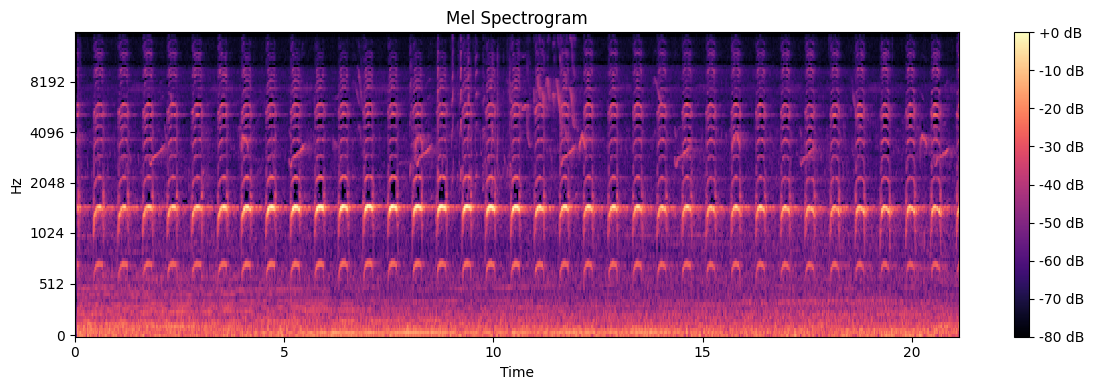

In [20]:
# Plot mel spectrograms for 5 random samples
for i, row in df_train.sample(5).iterrows():
    print(f"Sample {i+1} - Primary Label: {row['primary_label']}")
    plot_mel_spectrogram(row['filepath'])

Preprocessing

The `preprocess_audio` function is designed to convert a raw audio file into a normalized **Mel spectrogram** that can be used as input to a machine learning model. First, it loads the audio file at the given `path` using Librosa’s `load` function, setting the desired sample rate (`sr`) and duration (in seconds). If the audio is shorter than the expected length (`sr × duration`), it pads the audio with silence (zeros) to ensure all inputs are the same length. If it is longer, it truncates the excess. Then, it computes the Mel spectrogram using `librosa.feature.melspectrogram`, which transforms the waveform into a visual time-frequency representation where each vertical slice represents the frequency content of a short segment of time, using the perceptual Mel scale. This Mel spectrogram is converted from a power scale to a decibel scale using `power_to_db`, making it easier for models to learn from. Finally, the spectrogram is normalized to the range 0 to 1 by subtracting the minimum value and dividing by the maximum, ensuring consistency in scale for all inputs. The result is a clean, normalized 2D array (with shape `[n_mels, time]`) that represents the audio and is ready for model training or inference.


In [21]:
def preprocess_audio(path, sr=cfg.SR, duration=cfg.DURATION, n_mels=cfg.N_MELS,
                     fmin=cfg.FMIN, fmax=cfg.FMAX, hop_length=cfg.HOP_LENGTH):
    
    y, sr = librosa.load(path, sr=sr, duration=duration)
    
    # Pad if audio is too short
    expected_length = sr * duration
    if len(y) < expected_length:
        y = np.pad(y, (0, expected_length - len(y)))
    else:
        y = y[:expected_length]
    
    # Create mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                         fmin=fmin, fmax=fmax, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize to 0-1
    mel_db -= mel_db.min()
    mel_db /= mel_db.max()
    return mel_db.astype(np.float32)  # shape: [n_mels, time]

The `BirdClefDataset` class is a custom PyTorch `Dataset` designed for audio classification using Mel spectrograms, specifically tailored to the BirdCLEF dataset. When initialized, it takes a DataFrame `df` that contains metadata and file paths for audio samples, a `label2id` dictionary that maps bird species (label names) to numerical class indices, and an optional `transform` for data augmentation or preprocessing.

The `__len__` method returns the total number of samples in the dataset, enabling PyTorch to iterate over it during training or evaluation. The `__getitem__` method is the core of this dataset class. For each index `idx`, it retrieves the corresponding row from the DataFrame, reads the file path and bird label, and uses the `preprocess_audio` function to convert the raw audio file into a normalized Mel spectrogram. If a transformation is provided (like data augmentation), it applies it to the spectrogram.

The resulting Mel spectrogram is then converted into a PyTorch tensor and reshaped by adding a channel dimension, making it compatible with CNN-based models (with shape `[1, n_mels, time]`). The label is converted to its corresponding numeric ID using the `label2id` dictionary and returned as a tensor. Ultimately, each call to the dataset yields a pair: a processed Mel spectrogram tensor and its corresponding class label tensor, making it suitable for training audio classification models.


In [22]:
class BirdClefDataset(Dataset):
    def __init__(self, df, label2id, transform=None):
        self.df = df.reset_index(drop=True)
        self.label2id = label2id
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row["filepath"]
        label = row["primary_label"]

        # Preprocess audio
        mel = preprocess_audio(filepath)  # shape: [n_mels, time]

        if self.transform:
            mel = self.transform(mel)

        # Convert to tensor and add channel dimension
        mel = torch.tensor(mel).unsqueeze(0)  # shape: [1, n_mels, time]

        # Convert label to index
        label_idx = self.label2id[label]

        return mel, torch.tensor(label_idx, dtype=torch.long)

In [23]:
# Create label-to-index and index-to-label mappings
unique_labels = sorted(df_train["primary_label"].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

Model



### Overview of `timm`

* `timm` stands for "PyTorch Image Models".
* It is a library that provides many pretrained models such as ResNet, EfficientNet, ConvNeXt, etc.
* Useful for quick experimentation and model development in computer vision tasks.

### BirdCLEFModel Class Breakdown

#### `__init__()` method

* Initializes the model with three arguments:

  * `model_name`: name of the model architecture to load from `timm`.
  * `num_classes`: total number of bird species (output classes).
  * `pretrained`: whether to load pretrained weights (usually from ImageNet).

#### Backbone

* `timm.create_model()` is used to load a pretrained CNN without the classification head.
* `in_chans=1`: model accepts 1-channel input (for grayscale mel spectrograms).
* `num_classes=0`: disables the original classifier in the model.
* `global_pool='avg'`: includes a global average pooling layer to produce a fixed-size feature vector.

#### Classifier

* `self.classifier = nn.Linear(...)` is a custom fully connected layer.
* It maps the backbone’s feature output to the desired number of classes.

#### forward() method

* Takes input `x` (a batch of mel spectrograms).
* Passes it through the backbone to extract features.
* Passes the features through the classifier to get class logits.
* Returns predictions for each input sample.

### Purpose

* Leverages a powerful vision backbone for processing audio-derived images.
* Uses transfer learning to improve performance with less data and training time.
* Separates feature extraction and classification for flexibility and efficiency.


In [24]:
class BirdCLEFModel(nn.Module):
    def __init__(self, model_name=cfg.MODEL_NAME, num_classes=cfg.NUM_CLASSES, pretrained=cfg.PRETRAINED):
        super(BirdCLEFModel, self).__init__()
        
        # Use timm backbone with no classifier, include pooling
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            in_chans=1,
            num_classes=0,
            global_pool='avg'  # this handles pooling internally
        )
        
        # Add classifier
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)      # shape: (B, features)
        x = self.classifier(x)    # shape: (B, num_classes)
        return x

In [25]:
# Create sample dataset and dataloader
sample_df = df_train.sample(8).reset_index(drop=True)
dataset = BirdClefDataset(sample_df, label2id=label2id)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Instantiate model
model = BirdCLEFModel().to(cfg.DEVICE)

# Get a batch of data
batch = next(iter(dataloader))
inputs, targets = batch
inputs = inputs.to(cfg.DEVICE)

# Forward pass
outputs = model(inputs)

# Display shapes
print(f"Input shape      : {inputs.shape}")   # [B, 1, 128, time_steps]
print(f"Output shape     : {outputs.shape}")  # [B, num_classes]
print(f"Target labels     : {targets}")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Input shape      : torch.Size([4, 1, 128, 313])
Output shape     : torch.Size([4, 206])
Target labels     : tensor([ 74, 121, 162, 108])


Training Loop

In [26]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(cfg.DEVICE), labels.to(cfg.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), acc

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(cfg.DEVICE), labels.to(cfg.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), acc

* The function initializes the optimizer using Adam, which adapts the learning rate during training based on gradients. It takes the model parameters and a learning rate as inputs.

* The loss function used is CrossEntropyLoss, suitable for multi-class classification, measuring the difference between predicted probabilities and true labels.

* If resuming training is enabled and a checkpoint path is provided, the function loads the saved model weights, optimizer state, the last completed epoch, and the best validation accuracy so far. This allows training to continue from where it left off, saving time and resources.

* The training loop runs from the start epoch (either zero or after the checkpoint) through the specified number of epochs.

* For each epoch, the model is trained on the training dataset by running a full pass, updating weights through backpropagation, and calculating training loss and accuracy.

* After training, the model is evaluated on the validation dataset without updating weights, to measure how well it generalizes to unseen data.

* The time taken for each epoch is measured to monitor training speed and help estimate total training duration.

* After each epoch, a checkpoint is saved containing the current epoch number, model parameters, optimizer state, and validation accuracy. This ensures training progress can be restored if interrupted.

* If the current validation accuracy exceeds the best recorded accuracy, the model’s weights are saved separately as the best model, and the label-to-index mapping is saved as a JSON file for use during inference.

* At the end of training, the highest validation accuracy achieved is printed as a summary of model performance.

* This setup enables efficient, reproducible training, allowing interruptions to be handled gracefully and ensuring the best model is preserved for deployment or further use.


In [27]:
# Training function with checkpoint saving
def train_model(model, train_loader, val_loader, epochs=cfg.EPOCHS, lr=cfg.LR, resume=False, checkpoint_path=None):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0
    start_epoch = 0

    # Load from checkpoint if resuming
    if resume and checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_acc = checkpoint.get('val_acc', 0.0)
        print(f"Resumed from checkpoint: {checkpoint_path} | Starting at epoch {start_epoch + 1}")

    for epoch in range(start_epoch, epochs):
        print(f"\n Epoch {epoch+1}/{epochs}")

        start = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)
        end = time.time()
        print(f" Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
        print(f" Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
        print(f" Time: {(end - start):.2f}s")

        # Save checkpoint every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, f"/kaggle/working/checkpoint_epoch_{epoch+1}.pth")

        # Save best model and label2id mapping
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # Save model
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
            print("Best model saved.")

            # Save label mapping
            with open("/kaggle/working/label2id.json", "w") as f:
                json.dump(label2id, f)
            print("label2id mapping saved.")

    print(f"\n Best Validation Accuracy: {best_val_acc:.4f}")

In [28]:
# Spliting training data
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['primary_label'], random_state=cfg.SEED)

train_dataset = BirdClefDataset(train_df.reset_index(drop=True), label2id)
val_dataset = BirdClefDataset(val_df.reset_index(drop=True), label2id)

train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS)

# Initialize model
model = BirdCLEFModel().to(cfg.DEVICE)

# Launch training (can resume later with resume=True)
train_model(model, train_loader, val_loader, resume=False)


 Epoch 1/1


Training:   0%|          | 0/7617 [00:00<?, ?it/s]

Validating:   0%|          | 0/1905 [00:00<?, ?it/s]

 Train Loss: 3.5380 | Accuracy: 0.2525
 Val   Loss: 2.4866 | Accuracy: 0.4689
 Time: 3220.19s
Best model saved.
label2id mapping saved.

 Best Validation Accuracy: 0.4689
